<a id='intro'></a>
## Introduction

An A/B test of performig different landing pages on e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#The seed to assure you get the same answers 
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv'); df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df[df['converted'] == 1].user_id.nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` group don't match.

In [7]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0] +\
df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Drop them.

In [11]:
#list of rows to drop under the term that "treatment" does not match with  "new_page"
drop_list_1 = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index.tolist()
#list of rows to drop under the term that "new_page" does not match with  "treatment"
drop_list_2 = df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].index.tolist()

In [12]:
#drop unsuitable rows and store the result in new data frame df2
df2 = df.drop(drop_list_1 + drop_list_2)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page'))== False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [14]:
df2.nunique()


user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

Since we have timestamps for **290585** visits and only **290584** unique ids, we assume that one id is repeated in two sessions

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
#get the value of duplicated id
rep_id = df2[df2['user_id'].duplicated()].reset_index(drop = True).iloc[0,0]; rep_id

773192

c. What is the row information for the repeat **user_id**? 

In [16]:
#subset of data frame with duplicated usere_id
df2[df2['user_id'] == rep_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- Rows with the duplicated user_id **773192** has indexes **1899** and **2893** 
- These rows has different timestamps, same group **treatment** and same landing_page **new_page**

d. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [17]:
# drop the row with index 1899
df2 = df2.drop(1899); df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
actual_p_old = df2[(df2['group'] == 'control') & (df2['converted'] == 1)].shape[0]  / df2[df2['group'] == 'control'].shape[0]
actual_p_old

0.1203863045004612

In [20]:
df2[(df2['group'] == 'control') & (df2['landing_page'] == 'old_page')].shape[0] 

145274

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
actual_p_new = df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)].shape[0]  / df2[df2['group'] == 'treatment'].shape[0]
actual_p_new

0.11880806551510564

In [22]:
df2[(df2['group'] == 'treatment') & (df2['landing_page'] == 'new_page')].shape[0] 

145310

d. What is the probability that an individual received the new page?

In [23]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

Actual diffenrence between conversions

In [24]:
act_diff = actual_p_new - actual_p_old; act_diff

-0.0015782389853555567

Consider the results from above we **don't have statistically significant evidence** that new page leads to more conversions.
As we see, the probability that an individual received the new page in our test is 0.5. This confirmed by followed absolute numbers:
- the number of individuals in the treatment group received new page is **145310**
- the number of individuals in the control group received old page is **145274**

These digits allowed us to say that we comparing equal numbers of tests old page and new page. And the test is fair enough.

Based on the probability of converting we got above, we see that number for the new page is **0.1188** and it is less than the probability for old page **0.1204**. 

Technically speaking these numbers almost even, so instead of the statement that old page converts more, the preferred statement is 
> "we don't have statistically significant evidence that new page converting more, then old page"

<a id='ab_test'></a>
### Part II - A/B Test


In terms of words:
> NULL is : The conversion of new page not more than conversion of old page

> ALT is: The convesion of new page bigger than convirsion of old page


In terms of notation:


**<center>NULL :           $P_{new} - P_{old} <= 0$</center>**
    
**<center>ALT :               $P_{new} - P_{old} > 0$</center>**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
# p_new value from array simulated above
p_new_2 = (new_page_converted == 1).sum() / len(new_page_converted); p_new_2

0.11991604156630652

In [29]:
# p_old value from array simulated above
p_old_2 = (old_page_converted == 1).sum() / len(old_page_converted); p_old_2

0.12017291463028484

In [30]:
#difference between new p_new and p_old
p_new_2 - p_old_2

-0.00025687306397832732

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    p_new_2 = (new_page_converted == 1).sum() / len(new_page_converted)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_old_2 = (old_page_converted == 1).sum() / len(old_page_converted)
    p_diffs.append(p_new_2 - p_old_2)


In [32]:
#an array of simulated differences between probabilities of conversion with the new page and the old page
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  

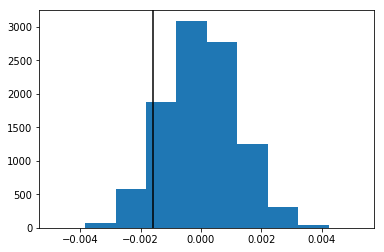

In [33]:
plt.hist(p_diffs)
plt.axvline(act_diff, color = 'black'); # point to the the actual difference between conversion rates, observed in data set

This histogram looks like what we expected to get as we made the big enough sampling to perform our testing. Under the central limit theory, the big enough sampling distribution should be the normal distribution with the bell-shaped graph. Anyway - let's check it twice with another method...

In [34]:
#the standart diviation of values in simulated array
p_diffs_std = np.std(p_diffs); p_diffs_std

0.0012071194538169593

In [35]:
#the simulated array with std-value we got above and under the NULL statement
null_valls = np.random.normal(0, p_diffs_std, 10000)

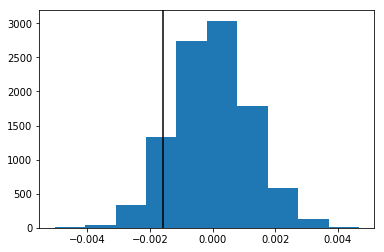

In [36]:
plt.hist(null_valls)
plt.axvline(act_diff, color = 'black');

Both graph looks very similar

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
#as we assume in point 2 - for the actual observed data in ab_data.csv - the p_new equal to p_old, so the observed p_diff is zero
# lets compare our simulated p_diffs with zero
(p_diffs > act_diff).sum() / len(p_diffs)

0.90210000000000001

Lets build the confident interval for our sampling distribution

In [38]:
np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

(-0.0023626990324980869, 0.0023791463260130455)

**Conclusion**
The number 0.90 we just got in part j** is a **P-value** under the NULL statement. 

Since the  P-value under the NULL is greater than Type I error rate 5% (90% > 5%) - we fail to reject the NULL statement

In the semi-terms of words, 0.90 is the probability that our observed data comes out from NUll hypotheses. While our P-value higher than Type I Error rate, this probability concider high enough to reject the idea that NULL hypothesis is false.

By another way to make a decision - our observed difference of conversions lies inside our confident interval of sampling distribution under the NULL hypotheses.<br> This statement may be expressed this way: -0.00237 < act_diff == -0.0015 < 0.0024. It is mean, that NULL Hypothesis more likely to fit with real observed data, than ALT hypotheses. 

In the full-terms of words - the results of our experiment do not show statistically significant evidence that the conversion of new landing page much better than the conversion of the old landing page.<br><br><br>